In [1]:
# Copyright notice
__author__ = "Matteo Lulli"
__copyright__ = "Copyright (c) 2020-2021 Matteo Lulli (lullimat/idea.deploy), matteo.lulli@gmail.com"
__credits__ = ["Matteo Lulli"]
__license__ = """                                                                                                                                        
Permission is hereby granted, free of charge, to any person obtaining a copy                                                                             
of this software and associated documentation files (the "Software"), to deal                                                                            
in the Software without restriction, including without limitation the rights                                                                             
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell                                                                                
copies of the Software, and to permit persons to whom the Software is                                                                                    
furnished to do so, subject to the following conditions:                                                                                                 
                                                                                                                                                         
The above copyright notice and this permission notice shall be included in all                                                                           
copies or substantial portions of the Software.                                                                                                          
                                                                                                                                                         
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR                                                                               
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,                                                                                 
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE                                                                              
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER                                                                                   
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,                                                                            
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE                                                                            
SOFTWARE.                                                                                                                                                
"""
__version__ = "0.1"
__maintainer__ = "Matteo Lulli"
__email__ = "matteo.lulli@gmail.com"
__status__ = "Development"

# Tutorial: Two-dimensional Ising Model

Welcome to this tutorial on how to build a module for the two-dimensional Ising model using the *root* classes of the **idea.deploy** framework.

This tutorial will guide you in a step-by-step way into the process of developing a Metropolis Monte Carlo simulation for the two-dimensional Ising model. We will be implementing the simple local Metropolis Monte Carlo update which allows for an easy parallelization of the implementation: the update of the spins can be performed throughout half of the system each time by emplying a checkerboard pattern. Blue and red sites can be alternatively updated in parallel. Hence we will end up distinguishing, one way or another, the site parity of the spin, i.e. its color on the checkerboard. The first implementation will be straightforward at the expense of being GPU-memory-unfriendly: given a block of threads only half of them will be active at one time. Such a choice automatically leads to halving the efficiency of the card. However, this is done for the sake of clarity in the first implementation. Subsequent versions will include more efficient memory managment basically relying on the separate allocation of the sites belonging to one of the two checkeboard colors. This will be done with different degrees of complication

- starting first from a simple implementation where spin variables are represented by a signed integer (```int```), 
- then shifting to using unsigned chars (```unsigned char```), and 
- finally land on an asynchronous-multi-spin-coded (aMSC) implementation where the spin variables will be stored in the bits of unsigned integers (```unsigned int``` or ```unsigned``` according to the architecture) and will be updated in parallel. 

The last step allows for roughly a 32-fold factor gain in performance with respect to the simples signed integer representation since we will be simulating 32 systems in paraller. This is done at the cost of introducing a small correlation between different realizations of the system. At the same time, this process will allow to have a faster convergence of the statistical analysis.

During this process we will shift strategy for the memory addressing going from a straightforward geometrical implementation which will then evolve to a checkerboard separation and finally end in a **sliced** scheme which allows for a better alignement of the memory reads while halving the number of MPI memory transfers in the multi-process implementation.

We will be measuring the performance differences with the built-in tools of the **idea.deploy** framework and also develop some standard statistical analysis tools along the way.

This tutorial is clearly *physics-oriented* and serves the double purpose of illustrating the functionalities of the framework while being *educational* as far as the two-dimensional Ising model and simple statistical analysis are concerned.

I will be constantly pushing updates on the *develop* branch of this project so that the last version can simply be retreived by constantly pulling the modifications to the repository.

I will also keep the tutorial finely grained in such a way that each subsection is self-consistent with each new class being a copy of the previous one and simply distinguished by a ```V#``` suffix.

## Bare-code implementation

In [2]:
# Development cell: it automatically reloads modified code in the various modules
%load_ext autoreload
%autoreload 2

In [3]:
'''
Setting the path for including idpy modules
'''
import sys
sys.path.append("../")

As a first step we define some custom C types which we will use when writing the kernels code. In the framework **idea.deploy** we wish to promote the general practice of declaring as many custom types as possible. The reason is that this allows for much flexibility and somewhat more expressive code. Furthermore, the programming model we wish to propose is such that the inclusion of constant values can be obtained directly in compiler macros. This strategy is actually convenient because at every (first) kernel launch the code is automatically generated and compiled and the constants that are passed are only used for the given instance. Hence, in principle, it would be possible to make several kernels, compiled with several sets of flags, interact in sequence on the same data.

Indeed, this is one of the main advantages of this approach, i.e. to be able to keep on reusing the allocated memory *while* writing new kernels that can be tested on the memory allocated even before the kernel classes have been defined. This solution offers great advantages during the development phase sparing compile and execution time while introducing the unified environment of a Jupyter notebook where the devlopment and testing processes naturally merge.

We define the custom types with the code in the cell below using the **idpy** module and class ```CustomTypes```. We declare an object ```CustomTypes``` by passing a ```dict``` to the constructor containing the custom type name as the key and the corresponding ```C``` type as the value. In this first implementation we will be using 32-bits variables.

### Custom Types

In [4]:
from idpy.Utils.CustomTypes import CustomTypes

Ising2DTypes_V0 = CustomTypes({'SpinType': 'int', 
                               'LatticeType': 'int',
                               'WeightType': 'float', 
                               'BetaType': 'float'})

The class ```CustomTypes``` offers several methods but its basically a wrapper of a ```dict```. We get the list of the custom type names with the ```ToList``` method

In [5]:
Ising2DTypes_V0.ToList()

['SpinType', 'LatticeType', 'WeightType', 'BetaType']

We can get the specific *value* of a custom tyoe by using suqare brackets as an *array* or ```dict```

In [6]:
Ising2DTypes_V0['SpinType']

'int'

We can delete a specific custom type from the object using ```Pop```. We call ```ToList``` right after in order to show the modification

In [7]:
Ising2DTypes_V0.Pop('BetaType')
Ising2DTypes_V0.ToList()

['SpinType', 'LatticeType', 'WeightType']

We can insert (restore) custom types by using the ```Set``` method. We call ```ToList``` right after in order to show the modification

In [8]:
Ising2DTypes_V0.Set({'BetaType': 'float', 'EnergyType': 'int'})
Ising2DTypes_V0.ToList()

['SpinType', 'LatticeType', 'WeightType', 'BetaType', 'EnergyType']

Finally we illustrate the method that is used in order to pass the custom types to the class ```IdpyKernel```, i.e. the ```Push``` method which simply returns a ```dict```

In [9]:
Ising2DTypes_V0.Push()

{'SpinType': 'int',
 'LatticeType': 'int',
 'WeightType': 'float',
 'BetaType': 'float',
 'EnergyType': 'int'}

### From Custom Types to numpy types

Next, we need a *dictionary* from our custom types we just declared in the object ```Ising2DTypes_V0```, to the numpy types which are necessary for allocating the device memory.

The framework offers a translation dictionary from ```C``` to numpy types in the class ```NpTypes```. We declare an object ```NPT_V0```

In [10]:
from idpy.Utils.NpTypes import NpTypes

NPT_V0 = NpTypes()

To check the full list of implemented types one can simply call the method ```ToList```

In [11]:
NPT_V0.ToList()

(['double',
  'float',
  'int',
  'unsigned int',
  'long long int',
  'unsigned long',
  'unsigned long long int',
  'char',
  'unsigned char'],
 [numpy.float64,
  numpy.float32,
  numpy.int32,
  numpy.uint32,
  numpy.int64,
  numpy.uint64,
  numpy.int8,
  numpy.uint8])

Or simply access the ```dict``` which are named according to the *argument* language. For instance, if we want to see to which numpy type the ```C``` ```float``` type correspond we just write

In [12]:
NPT_V0.C['float']

numpy.float32

and if we want to check to which ```C``` type the numpy type ```np.ubyte``` corresponds then we write

In [13]:
import numpy as np

NPT_V0.NP[np.ubyte]

'unsigned char'

Hence, in order to obtain the numpy type associated to the custom type, say, ```SpinType``` we just defined above, all we have to do is to write`b

In [14]:
NPT_V0.C[Ising2DTypes_V0['SpinType']]

numpy.int32

### Constants declaration

Now we declare some constants, i.e. values that will not change during the execution of the kernels, that will be passed as precompiler flags (i.e. macros) by the class ```IdpyKernel```. This is done by simply defining a ```dict``` of the constants one wants to declare.

In the present case of a two-dimensional Ising model we wish to pass as a constant the linear size of the domain ```L``` and the value of the inverse temperature ```beta``` that we choose to be 5% below the inverse of the critical temperature

$$T_c = \frac{2}{\ln(1 + \sqrt{2})}$$

In [15]:
constants_V0 = {'L': 16, 'beta': (1 + 0.05) * np.log(1 + np.sqrt(2)) / 2}
constants_V0['V'] = constants_V0['L'] ** 2

### Getting the *tenet* for the chosen device and architecture

First of all we would like to actually *see* what are the available devices and languages available on the system. On MacOs platforms only OpenCL will be available, while for Linux platforms with CUDA both OpenCL and CUDA will be available. The **ideal.deploy** framework offers the function ```IdpyHardware``` which lists devices and languages available

In [16]:
from idpy.IdpyCode import IdpyHardware

IdpyHardware()

CUDA Found!

CUDA GPU[0]
Name :  GeForce GTX 1070
Memory :  8511881216
DrvVersion :  (11, 2, 0)

OpenCL Found!

Listing GPUs:
OpenCL GPU[0]
Name :  GeForce GTX 1070
Memory :  8511881216
Double :  63
DrvVersion :  460.32.03


Listing CPUs:


Now we declare a few variables that are referred to in a consistent way throughout the framwork, namely ```lang```, ```device``` and ```cl_kind```. The variable ```lang``` can take two values, namely ```CUDA_T``` or ```OCL_T```. Both of these should be imported from ```idpy.IdpyCode``` and they can be chosen according to the result of the cell above. Below, we will make the assumption of using OpenCL so that ```lang = OCL_T```, however, make sure to change it to ```CUDA_T``` need there be. Also, with OpenCL there is the option of choosing a given type of device, either ```cpu``` or ```gpu```. Finally, the device number is also necessary and self-explaining

In [17]:
from idpy.IdpyCode import CUDA_T, OCL_T

lang_V0, cl_kind_V0, device_V0 = OCL_T, 'gpu', 0

Now, we are ready to use the function ```GetTenet``` which can be imported from ```idpy.IdpyCode```. As explained in the the wiki of the **idea.deploy** project the concept of *tenet* is at the heart of the project itself. A *tenet* is a language-agnostic object that contains all the necessary information about a context (either CUDA or OpenCL) that is created on a device. The *tenet* needs to be created and then passed to all functions that operate on a given device, i.e. memory allocation and kernels. It is always possible to create more than a *tenet* on a single device at the same time, or to create more than a *tenet* on multiple devices corresponding to different architectures, e.g. an OpenCL CPU and a CUDA GPU. This allows for extreme flexibility in managing the resources available on a given computer.

In the cell below we import the function ```GetTenet``` and instantiate the *tenet* object. The constructor needs the arguments to be passed in a ```dict```. We use the variables defined in the cell above. The reason for using of a ```dict``` for the ```GetTenet``` function is that it becomes easier to handle when called in more complex simulations classes (see ```idpy.LBM.LBM.SCMultiPhase``` for an example).

In [18]:
from idpy.IdpyCode import GetTenet

tenet_V0 = GetTenet({'lang': lang_V0, 'device': device_V0, 'cl_kind': cl_kind_V0})

OpenCL:  Device: 0 GeForce GTX 1070 Memory:8511881216


We will not dwelve on the details of the *tenet* class here. More technical information will be available in the wiki and in other tutorials.

### Memory allocation

Now, we can allocate the memory we will be using for the simulations. Basically, we only need the lattice of spins which is allocated in the cell below using ```idpy.IdpyCode.IdpyMemory```. There are many methods that can be used to allocate memory through ```IdpyMemory```. In this tutorial we will only use the methods we actually need. More technical details will be available on the wiki.

We are going to use the ```IdpyMemory.Zero``` method to allocate memory and set it to zero. We will do so on the device for which the *tenet* object above ```tenet_V0``` was created. Some of the arguments of the constructor closely resemble those of numpy arrays. This choice closely adapts to the Pycuda and Pyopencl implementation that constitute the columns of the **idea.deploy** project.

In [19]:
from idpy.IdpyCode import IdpyMemory

spins_V0 = IdpyMemory.Zeros(shape = constants_V0['V'], 
                            dtype = NPT_V0.C[Ising2DTypes_V0['SpinType']], 
                            tenet = tenet_V0)

### Allocating the pseudo-random number generator

Now we allocate the PRNG for the Monte Carlo simulation. This is an essential ingredient that needs to be chosen with some care. Interestingly, in the previous publication [[Highly optimized simulations on single- and multi-GPU systems of the 3D Ising spin glass model](https://doi.org/10.1016/j.cpc.2015.06.019)] it was found that running a large number of congruential PRNGs in parallel would still allow to have good quality pseudo-random numbers, even if each stream would clearly be of low quality in itself. 

Hence, we use the ```CRNGS``` class from the ```idpy.PRNGS.CRNGS``` module which allows to implement one of three different kinds of congriential PRNG. Given our choice of using 32-bits variables to begin with, we are going to use the ```NUMREC``` implementation (NUMerical RECipes). This also allows to run these simulations on all OpenCL supported devices. The number of PRNGs to be run in parallel is assigned by ```n_prngs```. The present implementation requires to specify again the language but this should be improved in the future by reading the language from the *tenet* when assigned like in this case.

The state of the PRNG is initialized with the numpy PRNG wih a default seed equal to 1. Other options for the use of the class ```CRNGS``` are available on the wiki. A relevant information is that an object of the class ```CRNGS``` also comes with (at least) a predefined custom type ```CRNGType``` which we will need to include when passing the custom types to the kernel.

In [20]:
from idpy.PRNGS.CRNGS import CRNGS

numrec_V0 = CRNGS(n_prngs = constants_V0['V'], kind = 'NUMREC', 
                  tenet = tenet_V0, lang = lang_V0)

We also need to define the custom type ```RANDType``` which we need to use for computing normalized random numbers. For the moment we set it to ```float``` in order to assure 32-bits compatibility.

In [21]:
numrec_V0.custom_types.Set({'RANDType': 'float'})

Now, we need to merge the ```custom_types``` object of ```numrec_V0``` with the ```Ising2DTypes_V0``` object we want to use for the simulations

In [22]:
Ising2DTypes_V0.Set(numrec_V0.custom_types.Push())

Ising2DTypes_V0.Push()

{'SpinType': 'int',
 'LatticeType': 'int',
 'WeightType': 'float',
 'BetaType': 'float',
 'EnergyType': 'int',
 'CRNGType': 'unsigned int',
 'RANDType': 'float'}

An the constants which will be used as precompiler macros

In [23]:
constants_V0 = {**numrec_V0.constants, **constants_V0}

constants_V0

{'ID_RANDMAX': 4294967295,
 'N_PRNGS': 256,
 'F_CRNG': 'F_NUMREC',
 'L': 16,
 'beta': 0.46272113318526004,
 'V': 256}

### Memory Initialization

Now, we want to initialize the state of the system such that the initial magnetization is zero on average. To do this we just need to initialize the spin variables with a random distribution of +1 and -1s which we can obtain by means of the congruential PRNG object ```numrec_V0``` we just instatiated. Of course, it is also possible, and more convenient, to use numpy instead. However, this gives us an excuse to see how to use the ```CRNGS``` class.

This is simply done by using the object as a function since the merhod ```__call__``` is defined. This will automatically output the state of the set of PRNGs as a numpy array. Since we allocated only half of th e *volume* of the system we need to call it twice and to concatenate the output. All these operations are only possible using numpy functions. Hence, we will implicitly import numpy as well.

Finally, in order to get the random distribution of +1 and -1 we only need to check the *parity* of the numbers which should be evenly distributed.

Let us begin by showing the output obtained by calling the CRNGS object ```numrec_V0``` as if it was a function, i.e. ```numrec_V0()```

In [24]:
numrec_V0()

array([3343220045, 1199212379, 1533250440, 1194463508, 2691327583,
       2503466337, 1519511483,  645719085,  380118639, 1029380652,
        589250748, 3305559545,   62873288, 1551838471, 3016652149,
       1135145784, 2608000314, 1766500785,  674751094, 3941081968,
       4266122834, 3567688077,  969907158, 3294171440,  499089787,
       2853727800, 2848819790, 1110897496, 2468037221, 2342287778,
        706421238, 3744323296, 2215598679,  306897239, 1809451585,
       3323643305, 3447517431, 3991380402,  463518028, 2485343690,
       2515945109,  219162177, 3561869153,  728094663, 2694960031,
       2169436549, 2321011850,  458715985, 3778888057,  258927340,
       1690468728, 4286267913, 1912109780, 3337481828, 3870487701,
       3221422915,  947726671,   81978446, 1667948433, 3969546388,
         18524402, 2644802311, 1712833299, 1131350138, 1329983997,
       1957099497,  814601041, 2738066835, 4241332832,   82778532,
       3852507305, 3224258971,  807629640, 3259208382, 2300407

Now, we can use the parity of these number to initialize the spins as follows:
- We normalize by the CNRG constant ```ID_RANDMAX``` and check which numbers are larger than ```0.5```.
- Since the resulting array will contain ```bool```s, and we want to obtain a +1/-1 sequence, we which can be understood as *occupation* numbers $n_i$, we will use a very well known transformation to +1/-1 spin variables $\sigma_i$ given by $$\sigma_i = 2 n_i - 1$$

All these operations can be easily implemented given the properties of numpy arrays. In order to have a cleaner code we decleare a temporary variable ```_swap_rand``` that will constantly be reassigned, exactly because we should not take into account any consistency of this variable while using the code. We need to use it quickly and be able to quickly forget about it.

In [25]:
_swap_rand = numrec_V0()

'''
After the next operation the array contains only boolean values
'''
_swap_rand = _swap_rand / numrec_V0.constants['ID_RANDMAX'] > 0.5
'''
We apply the occupation number transformation formula
'''
_swap_rand = 2 * _swap_rand - 1
_swap_rand = _swap_rand.astype(NPT_V0.C[Ising2DTypes_V0['SpinType']])
_swap_rand

array([-1,  1, -1, -1,  1,  1,  1, -1, -1, -1,  1,  1,  1, -1, -1,  1, -1,
        1,  1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1,  1,  1,  1,  1, -1,
        1, -1,  1, -1,  1, -1,  1, -1, -1, -1,  1,  1, -1,  1, -1, -1, -1,
        1, -1, -1, -1,  1, -1, -1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
       -1, -1,  1,  1, -1, -1,  1,  1, -1,  1,  1,  1,  1,  1, -1,  1,  1,
       -1,  1, -1, -1, -1,  1, -1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1,
        1,  1, -1, -1, -1, -1, -1,  1, -1, -1, -1,  1,  1,  1,  1, -1,  1,
        1, -1, -1,  1,  1, -1,  1,  1,  1,  1,  1, -1, -1,  1,  1, -1,  1,
        1, -1,  1,  1, -1,  1,  1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,
        1,  1, -1,  1, -1, -1, -1,  1,  1,  1, -1, -1,  1, -1, -1, -1, -1,
       -1,  1, -1,  1,  1,  1, -1,  1,  1, -1, -1,  1, -1, -1, -1,  1, -1,
       -1,  1, -1, -1,  1, -1, -1, -1,  1,  1, -1, -1, -1,  1,  1, -1,  1,
       -1,  1,  1,  1,  1, -1, -1,  1, -1,  1,  1, -1, -1, -1, -1,  1, -1,
        1, -1,  1,  1, -1

We can obtain the magnetization of the system by simply using the ```numpy``` function ```mean```, which indeed should be compatible with zero. We can check this by computing the sample error by means of the square root of the variance nornalized by the number of points. The mean should be compatible with zero withing 2 standard deviations.

In [26]:
_swap_mag_ave = np.mean(_swap_rand)
_swap_mag_err = np.sqrt(np.var(_swap_rand) / constants_V0['V'])

print("Magnetization:", _swap_mag_ave, "+/-", _swap_mag_err)

Magnetization: 0.0234375 +/- 0.062482831504246716


Finally, we transfer the initial spin configuration contained in ```_swap_rand``` in the device memory object ```spins_V0``` by means of the ```H2D``` (*host-to-device*) method.

In [27]:
spins_V0.H2D(_swap_rand)

### Metropolis Monte Carlo kernel

Now we have come to the point where we can write the crucial piece of code for studying the equilibrium properties and the phase transition of the two-dimensional Ising model. In order to so we need to sample the different system configurations typical of a given inverse temperature $\beta$ and average the various observables on this sequence of configurations. One of the most common and straigh-forward algorithms that allows us to do so, i.e. to generate a sample of equilibrium configurations according to the Boltzmann statistics, is the well known Metropolis algorithm.

Metropolis algorithm is a local algorithm that evaluates the probability for a spin $\sigma_i$ to be flipped (i.e. $\sigma_i \to -\sigma_i$) as a function of the energy difference $\Delta E_i$ resulting from the flip itself. The energy difference can be computed from the Hamiltonian to be 

$$ \Delta E_i = \mathcal{H}(-\sigma_i) - \mathcal{H}(\sigma_i) = [\sigma_i - (- \sigma_i)] \sum_{j\in \partial i} \sigma_j = 2\sigma_i \sum_{j\in \partial i} \sigma_j$$ 

where with $\partial i$ we indicate the four nearest neighbors of the spin $\sigma_i$. One the obtain the transition probability as 

$$W_{\sigma_i \to -\sigma_i} = \exp[-\beta \Delta E_i]$$ 

where we set $W_{\sigma_i \to -\sigma_i} = 1$ for $\Delta E_i < 0$. In order to accept or refuse the move we will need to compare $W_{\sigma_i \to -\sigma_i}$ to a normalized pseudo-random number $r_i \in [0,1]$, so that the flip is accepted if $r_i < W_{\sigma_i \to -\sigma_i}$.

Let us now implement in the cell below this algorithm. We will be creating a ```class``` that is a child of ```IdpyKernel```. There are a few technical details for writing the class which are explained in the comments of the cell below.

In [28]:
from idpy.IdpyCode.IdpyCode import IdpyKernel
from idpy.IdpyCode import IDPY_T

# Kernel K_UpdateSpins_V0: click on the arrow to expand
class K_UpdateSpins_V0(IdpyKernel):
    '''
    class K_UpdateSpins_V0: child class of IdpyKernel
    The declaration of the constructor is somehow 'kindly forced' 
    to contain all the optional arguments, mainly for memorizing reasons, 
    or to easily retrieve the definition from previously written code.
    custom_types: is passed by using CustomTypes.Push()
    constants: is a dictionary of all the constant/macros definition
    f_classes: list of IdpyFunction classes used as device function
    optimizer_flag: boolean, toggles compiler optimizer'''
    def __init__(self, 
                 custom_types = {}, constants = {}, f_classes = [], 
                 optimizer_flag = None):
        '''
        Calling right away the constructor of the parent class to setup all
        inherited variables
        '''
        IdpyKernel.__init__(self, 
                            custom_types, constants = constants, f_classes = f_classes, 
                            optimizer_flag = optimizer_flag)
        '''
        We set the 'g_tid' flag that automatically gives access to the `global thread id`
        i.e. the sequential (lexicographic) thread index that the IdpyKernel parent class
        automatically instatiates according to CUDA or OpenCL computing models.
        When writing the code we can use the (unsigned int) variable g_tid
        to access the thread id and in turn use it to access the desired memory location.
        Other indexing options are available and are listed in the wiki.'''
        self.SetCodeFlags('g_tid')
        '''
        We can use the class attribute 'params' as part of the function/method
        declaration in C. It simply consists of a dictionary where we list the 
        arguments to be passed to the kernel in C style as the keys of the arguments
        whose descriptors, which are CUDA/OpenCL dependent, are passed as a list for the
        key value. The written implementation below gives a better idea.
        
        All we need to pass to the kernel are the spins and the inverse temperature beta 
        for this simple implementation. We also pass the parity of the sites to execute
        the update on so that we can update the whole system with only one function
        which will be called twice.
        Finally, we need the seeds for the random number generator.'''
        self.params = {'SpinType * spins': ['global', 'restrict'],
                       'CRNGType * seeds': ['global', 'restrict'],
                       'LatticeType parity': ['const']}
        '''
        Now, we write the kernel itself which only consists in a string.
        An implicit option we pass to the kernel lies in which entry of the
        dictionary `kernels` we choose to define. Indeed it is possible to define
        language specific kernels for both CUDA and OpenCL in order to maximize the 
        efficiency of the kernel itself. However, in running for physics results
        a compromise between extreme optimization and time-to-result should be 
        looked for such that the most results can be obtained with the smallest effort.
        In this perspective we choose to define the idea.deploy metalanguage as a first
        good trade-off efficiency-wise. This choice is implemented by defining 
        the `[IDPY_T]` entry of the kernels dictionary. 
        Indeed, most bottle necks primarily come out
        of bad programming in the first place, rather than from poor optimization.
        Further on, if any language-specific features will be desirable we
        will write language-specific kernels by defining the `[CUDA_T]` and `[OCL_T]`
        entries.
        
        Now, watch out, the commenting style and the syntax of the next lines
        are in the C fashion.'''
        self.kernels[IDPY_T] = """
        // First of all we check if the the thread-id is inside the
        // system size domain. We do this since, performance-wise,
        // it is much more convenient to simply define a grid that is overall
        // a little larger than necessary but with the benefit of having
        // thread blocks of a convenient `canonical` size, e.g. 128
        if(g_tid < V){
            // Let's read the value of the local spin corresponding
            // to the thread id
            SpinType lspin = spins[g_tid];
            // First, we get the thread id lattice coordinates
            LatticeType x = g_tid % L, y = g_tid / L;
            // We check the parity of the site
            if(((x & 1U) ^ (y & 1U)) == parity){
                // Next we get the neighbors indices using periodic
                // boundary conditions. We use here the simplest linear
                // indexing with strides.
                LatticeType spx = (x + 1) % L + y * L; 
                LatticeType spy = x + ((y + 1) % L) * L;
                LatticeType smx = (x - 1 + L) % L + y * L;
                LatticeType smy = x + ((y - 1 + L) % L) * L;
                // Then, we calculate the energy difference for flipping the spin
                EnergyType delta_e = 2 * lspin * (spins[spx] + spins[spy] + spins[smx] + spins[smy]);
                // Then, we compute the acceptance probability for the flip
                WeightType W = exp((BetaType)(- beta * delta_e));
                // Finally we compare this number to a random number normalized in [0,1)
                // First we get the seed
                CRNGType lseed = seeds[g_tid];
                // We compute the noramlized pseudo-random number which takes
                // the pointer of lseed since the seed need to be updated after being used
                // We put a little `spin` to the code here and update the spin with a branchless
                // operation by first converting it to an occupation number variable
                // which is then flipped if the normalized random number is larger than
                // the Boltzmann weight associated to the transition
                //
                // First, go to occupation number representation
                SpinType loccupation = (1 - lspin) / 2;
                // Second, flip if possible, convert back to spin representation and
                // write back to global memory
                spins[g_tid] = 1 - 2*(loccupation ^ (F_NormRand(&lseed) < W));
                // and finally we write the seed back in the global memory
                seeds[g_tid] = lseed;
            }
        }
        """

### ```F_NormRand``` Normalized pseudo-random number function

The ```IdpyKernel``` child class we defined above implicitly depends (to made explicit soon with a code update) on the function ```F_NormRand``` which is used to generate the normalized pseudo-random number. This function is actually provided by the module ```idpy.PRNGS.CRNGS.F_Norm``` and we import it in the cell below

In [29]:
from idpy.PRNGS.CRNGS import F_Norm

The *function* ```F_Norm``` is a child class of ```IdpyFunction``` belonging to the module ```idpy.IdpyCode```. The class ```IdpyFunction``` allows to define *device functions* as functions to be used inside *kernels*. We can make use of F_Norm in our *kernel* class above by simply defining a macro to somehow *rename* the function itself so that we can call it bu ```F_NormRand```. We do so by adding one entry to the constants ```dict```

In [30]:
constants_V0['F_NormRand'] = 'F_Norm'

### Inspecting Metropolis Kernel class

Now, we can quickly examine the compiler options and the output code of ```K_UpdateSpins_V0```. We create the associated object by simply adding a trailing `_` to the kernel class name. In the option ```f_classes``` we need to pass a list of the *device functions* ```IdpyFunction``` that shall be used by the kernel object. **BEWARE** if there is a inter-dependence of the ```IdpyFunction```'s passed in the list, and the function names are re-asigned through macros, then one should pass them in order like below. We will see later how this can be avoided by 'changing' the name of the ```IdpyFunction``` class by creating a very simple child class.

In [31]:
_K_UpdateSpins_V0 = K_UpdateSpins_V0(custom_types = Ising2DTypes_V0.Push(), 
                                     constants = constants_V0, 
                                     f_classes = [numrec_V0.F_CRNG, F_Norm])

We now inspect the behavior of the kernel object ```_K_UpdateSpins_V0```. Let us first look at the compilers macros that are set by the custom types ```Ising2DTypes_V0``` and by the constants ```constants_V0```. The function ```SetMacros``` takes the language ```CUDA_T``` or ```OCL_T``` as an argument.

In [32]:
_K_UpdateSpins_V0.SetMacros(lang = lang_V0)

' -D ID_RANDMAX=4294967295 -D N_PRNGS=256 -D F_CRNG=F_NUMREC -D L=16 -D beta=0.46272113318526004 -D V=256 -D F_NormRand=F_Norm -D SpinType="int" -D LatticeType="int" -D WeightType="float" -D BetaType="float" -D EnergyType="int" -D CRNGType="unsigned\tint" -D RANDType="float"'

Next, we can have a look at the code that is generated by the *kernel* object according to the language chosen, either ```OCL_T``` or ```CUDA_T```.

In [33]:
from IPython.display import Code 

Code(_K_UpdateSpins_V0.Code(lang = lang_V0), language = 'C')

void F_NUMREC(CRNGType * l_seed);
  void F_NUMREC(CRNGType * l_seed){

        *l_seed = (*l_seed) * 1664525U + 1013904223U;
        return;
        }

  RANDType F_Norm(CRNGType * l_seed);
  RANDType F_Norm(CRNGType * l_seed){

        F_CRNG(l_seed);
        return ((RANDType) (*l_seed)) / (ID_RANDMAX - 1);
        }

__kernel void K_UpdateSpins_V0(__global SpinType  *   spins,__global CRNGType  *   seeds,__const LatticeType parity){
unsigned int g_tid = 

                        get_global_id(0) + 
                        (get_global_id(1) + get_global_id(2) * get_global_size(1)) * get_global_size(0);

        // First of all we check if the the thread-id is inside the
        // system size domain. We do this since, performance-wise,
        // it is much more convenient to simply define a grid that is overall
        // a little larger than necessary but with the benefit of having
        // thread blocks of a convenient `canonical` size, e.g. 128
        if(g_tid < V){
            // Let's read the value of the local spin corresponding
            // to the thread id
            SpinType lspin = spins[g_tid];
            // First, we get the thread id lattice coordinates
            LatticeType x = g_tid % L, y = g_tid / L;
            // We check the parity of the site
            if(((x & 1U) ^ (y & 1U)) == parity){
                // Next we get the neighbors indices using periodic
                // boundary conditions. We use here the simplest linear
                // indexing with strides.
                LatticeType spx = (x + 1) % L + y * L; 
                LatticeType spy = x + ((y + 1) % L) * L;
                LatticeType smx = (x - 1 + L) % L + y * L;
                LatticeType smy = x + ((y - 1 + L) % L) * L;
                // Then, we calculate the energy difference for flipping the spin
                EnergyType delta_e = 2 * lspin * (spins[spx] + spins[spy] + spins[smx] + spins[smy]);
                // Then, we compute the acceptance probability for the flip
                WeightType W = exp((BetaType)(- beta * delta_e));
                // Finally we compare this number to a random number normalized in [0,1)
                // First we get the seed
                CRNGType lseed = seeds[g_tid];
                // We compute the noramlized pseudo-random number which takes
                // the pointer of lseed since the seed need to be updated after being used
                // We put a little `spin` to the code here and update the spin with a branchless
                // operation by first converting it to an occupation number variable
                // which is then flipped if the normalized random number is larger than
                // the Boltzmann weight associated to the transition
                //
                // First, go to occupation number representation
                SpinType loccupation = (1 - lspin) / 2;
                // Second, flip if possible, convert back to spin representation and
                // write back to global memory
                spins[g_tid] = 1 - 2*(loccupation ^ (F_NormRand(&lseed) < W));
                // and finally we write the seed back in the global memory
                seeds[g_tid] = lseed;
            }
        }
        return; }

It is easy to see that in the code above the *device function* ```F_Norm``` is declared and defined at the beginning. The compiler macro ```-D F_NormRand=F_Norm``` set by the value we set in the constants ```dict``` ```constants_V0['F_NormRand'] = 'F_Norm'``` allows to call the function in the kernel by ```F_NormRand```.

### Blocks and Grid

Before executing the kernel on the data we need to define the parameters for the threads grid. These parameters play a non-trivial role also for the efficient execution of the code. Here we use a simple strategy implemented in the functions ```idpy.IdpyCode.GridAndBlocks1D``` which takes as arguments the total number of threads and the block size and returns a one-dimensional grid and block variables that need to be fed to the *kernel* object ```_K_UpdateSpins_V0```. The function is written in such a way that the total number of threads obtained by multiplying ```grid``` and ```block``` can be larger than the one passed as an argument to the function. This is done since it is more important for the block to be of a given size (i.e. a multiple of the *warp*, i.e. a multiple of 32 threads) than for the grid to be exactly fitting. This is the reason why we included at an ```if``` statement checking if the thread id is inside the system volume.

Let us now import the ```GridAndBlocks1D``` function and define the ```grid_V0``` and ```block_V0``` variables

In [34]:
from idpy.IdpyCode import GridAndBlocks1D

'''
We set the total number of threads to be the equal to the volume knowing that half of
them will not be working
'''
grid_V0, block_V0 = GridAndBlocks1D(_n_threads_min = constants_V0['V'], _block_size = 128)
print("Grid:", grid_V0, "Block:", block_V0)

Grid: (2, 1, 1) Block: (128, 1, 1)


### Updating the spins configurations

Now we can start updating the spin configuration by calling the kernel twice on sites of different parity. In order to do we need our *kernel* object ```_K_UpdateSpins_V0``` to create an *idea* object that can be used to execute the kernel through the ```Deploy``` method. The *idea* object is created by invoking the *kernel* object as a function and passing to it as arguments the *tenet*, ```grid_V0``` and ```block_V0```. At this point the code gets compiled and any compiler error will be returned.

In [35]:
Idea_K_UpdateSpins_V0 = _K_UpdateSpins_V0(tenet = tenet_V0, grid = grid_V0, block = block_V0)

Now, it is possible to invoke the ```Deploy``` method which takes as arguments the list of the *kernel* arguments declared in the ```self.params``` ```dict```, exactly in the same order. In this case the kernel launch would look like

```
Idea_K_UpdateSpins_V0.Deploy([spins_V0, numrec_V0.sims_idpy_memory['seeds'],
                              NPT_V0.C[Ising2DTypes_V0['SpinType']](parity)])
```

the variable parity should alternatively be assigned to be ```parity = 0``` and ```parity = 1``` in order to execute a *sweep*. In the case of OpenCL the function will return an event and also can accept an event (or ```None```) as an argument. When executing kernels in a sequence for OpenCL we must make sure that each kernel call *waits* for the *event* of the previous call. This is automatically implemented in CUDA in which case all the *kernels* are exeuted on the stream ```0``` unless differently specified. In order to unify the two approaches in the *idpy metalanguage* we simply resort to the hybrid concept of ```idpy_stream``` which can be either a CUDA stream or a OpenCL event.

Let us write down in this perspective a function ```MainLoop_V0``` executing a loop for the spin updates which also accepts some other function as input in order to take some measurements on the system at regular intervals. As we shall see later most of the details we are handling now in ```MainLoop_V0``` are automatically handled by the class ```idpy.IdpyCode.IdpyCode.IdpyLoop``` which allows to easily instantiate as many ```idpy_stream```'s (CUDA or OpenCL) as desired in a relatively simple way. We will also measure the performance of the algorithm by using ```idpy.IdpyCode.IdpyCode.IdpyLoopProfile``` which, in the case of CUDA, has the peculiarity of needing to call the kernel one more time in order to assure a reasonable measure of the run-time. On the other hand the OpenCL implementation does not suffer such a difficulty so that ```IdpyLoopProfile``` would also produce physically consistent results.

In [36]:
from idpy.IdpyCode.IdpyCode import IdpyLoop

'''
MainLoop_V0 Code: click on the arrow to expand
'''
def MainLoop_V0(spins, crng, time_steps, lang, fs_check = [], print_flag = False):
    parity_reds, parity_blues = 0, 1
    memory_pool = {'spins': spins, 'seeds': crng.sims_idpy_memory['seeds']}    
    
    old_step, res = 0, {}
    for step in time_steps[1:]:
        if print_flag:
            print("Step:", step)
        if lang == OCL_T:
            idpy_stream_reds, idpy_stream_blues = None, None
            for i in range(step - old_step):
                '''
                Updating the reds first
                '''
                idpy_stream_reds = \
                    [Idea_K_UpdateSpins_V0.Deploy([spins_V0, crng.sims_idpy_memory['seeds'],
                                                   NPT_V0.C[Ising2DTypes_V0['SpinType']](parity_reds)], 
                                                  idpy_stream = idpy_stream_blues)]
                '''
                Updating the blues after
                '''            
                idpy_stream_blues = \
                    [Idea_K_UpdateSpins_V0.Deploy([spins_V0, crng.sims_idpy_memory['seeds'],
                                                   NPT_V0.C[Ising2DTypes_V0['SpinType']](parity_blues)], 
                                                  idpy_stream = idpy_stream_reds)]
        if lang == CUDA_T:
            idpy_stream_reds, idpy_stream_blues = None, None
            for i in range(step - old_step):
                '''
                Updating the reds first
                '''
                Idea_K_UpdateSpins_V0.Deploy([spins_V0, crng.sims_idpy_memory['seeds'],
                                              NPT_V0.C[Ising2DTypes_V0['SpinType']](parity_reds)])
                '''
                Updating the blues after
                '''            
                Idea_K_UpdateSpins_V0.Deploy([spins_V0, crng.sims_idpy_memory['seeds'],
                                              NPT_V0.C[Ising2DTypes_V0['SpinType']](parity_blues)])
                
                
        '''
        Measure observables
        '''
        for _f in fs_check:
            _swap_res = _f(spins)
            for _obs in _swap_res:
                if _obs not in res:
                    res[_obs] = []
                    res[_obs] += [_swap_res[_obs]]
                else:
                    res[_obs] += [_swap_res[_obs]]

        old_step = step
        
    return res

The simplest quantity we can check is the magnetization which can be easily obtained using the ```np.mean``` function. Close enough to the critical point (from below) and for small enough systems the magnetization should repeatedly flip between the two values $m(\beta)$ and $-m(\beta)$ which are related by spin-flip symmetry which in the absence of an external field $\mathcal{H}$ is an exact symmetry of the Hamiltonian. This is possible because for small sizes the free-energy barrier for nucleating a 'droplet' of aligned spins can be easily overcome. This happens because the free-energy cost for nucleating such a domain and then expand it is proportional to the perimeter of the domain which is, for small systems, relatively small.

Let's write below a function to compute the magnetization that gives as output a ```dict```

In [37]:
'''
Computing magnetization from the spins
'''
def ComputeMagnetization(spins):
    return {'mag1': np.mean(np.copy(spins.D2H()))}

and finally execute the function ```MainLoop_V0``` returning a dictionary with the results

In [38]:
'''
Simulation: First Run
'''
results_V0 = MainLoop_V0(spins_V0, numrec_V0, range(0, 2 ** 16 + 1, 2 ** 7), 
                         lang = lang_V0, fs_check = [ComputeMagnetization], print_flag = True)

'''
Transforming each entry of the results from a list to a numpy array
'''
for obs in results_V0:
    results_V0[obs] = np.array(results_V0[obs])

Step: 128
Step: 256
Step: 384
Step: 512
Step: 640
Step: 768
Step: 896
Step: 1024
Step: 1152
Step: 1280
Step: 1408
Step: 1536
Step: 1664
Step: 1792
Step: 1920
Step: 2048
Step: 2176
Step: 2304
Step: 2432
Step: 2560
Step: 2688
Step: 2816
Step: 2944
Step: 3072
Step: 3200
Step: 3328
Step: 3456
Step: 3584
Step: 3712
Step: 3840
Step: 3968
Step: 4096
Step: 4224
Step: 4352
Step: 4480
Step: 4608
Step: 4736
Step: 4864
Step: 4992
Step: 5120
Step: 5248
Step: 5376
Step: 5504
Step: 5632
Step: 5760
Step: 5888
Step: 6016
Step: 6144
Step: 6272
Step: 6400
Step: 6528
Step: 6656
Step: 6784
Step: 6912
Step: 7040
Step: 7168
Step: 7296
Step: 7424
Step: 7552
Step: 7680
Step: 7808
Step: 7936
Step: 8064
Step: 8192
Step: 8320
Step: 8448
Step: 8576
Step: 8704
Step: 8832
Step: 8960
Step: 9088
Step: 9216
Step: 9344
Step: 9472
Step: 9600
Step: 9728
Step: 9856
Step: 9984
Step: 10112
Step: 10240
Step: 10368
Step: 10496
Step: 10624
Step: 10752
Step: 10880
Step: 11008
Step: 11136
Step: 11264
Step: 11392
Step: 11520
Step:

### Physics Check: spontaneous magnetization and magnetization inversion

We show below the time sequence of the magnetization that as commented before repeatedly oscilates between the two symmetric values $m(\beta)$ and $-m(\beta)$. We can compare these values with the result from the analytical formula of Onsager

$$m(\beta) = \left(1 - \frac{1}{[\sinh(2\beta)]^4}\right)^{1/8}$$

which we define with a function in the cell below

In [39]:
'''
Function for Onsager's magnetization formula
'''
def M1Onsager(beta):
    beta_c = np.log(1 + np.sqrt(2)) / 2
    return 0 if beta < beta_c else (1 - ((np.sinh(2 * beta)) ** (-4))) ** (1/8)

So that we can superpose its value (dashed black line) to the time sequence (red continuous line) displaying a good matching.

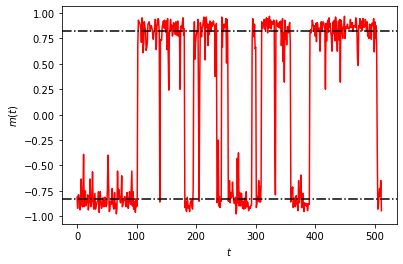

In [40]:
# Plotting results: click on the arrow to unfold
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(results_V0['mag1'], color = 'red')
plt.axhline(y = M1Onsager(beta = constants_V0['beta']), linestyle = '-.', color = 'black')
plt.axhline(y = -M1Onsager(beta = constants_V0['beta']), linestyle = '-.', color = 'black')
plt.xlabel('$t$')
plt.ylabel('$m(t)$')

plt.ioff()
plt.show()

### Physics Check: spontaneous magnetization as a function of $\beta$

Now, we can simulate a series of temperatures, both above and below the critical point, in order to show how such a simple implementation of the model basically captures the essential physics of the phase transition for the 2D Ising model.

In order to do so we need to change the value of $beta$ and create a new kernel object every time we do so. Finally we should collect the resulting magnetization sequences in a ```dict``` that can be indicized by the value of ```beta``` itself

In [41]:
'''
Setting a range of relative 'distances' delta_beta from the critical temperature
for executing the loop of simulations
'''
beta_results_V0, delta_beta_seq_V0 = {}, np.linspace(-0.1, 0.1, 2 ** 4)

'''
Loop over different temperature:
the different steps for initializing the simulations are detailed below.
Click on the arrow to unfold the code
'''
for _delta_beta in delta_beta_seq_V0:
    '''
    Set beta
    '''
    constants_V0['beta'] = (1 + _delta_beta) * np.log(1 + np.sqrt(2)) / 2
    print("Beta:", constants_V0['beta'])
    print()
    '''
    Initialize the spins
    '''
    _swap_rand = numrec_V0()
    _swap_rand = _swap_rand / numrec_V0.constants['ID_RANDMAX'] > 0.5
    _swap_rand = 2 * _swap_rand - 1
    _swap_rand = _swap_rand.astype(NPT_V0.C[Ising2DTypes_V0['SpinType']])
    spins_V0.H2D(_swap_rand)
    '''
    Create the new kernel object which will contain the new value of beta as a macro
    '''
    _K_UpdateSpins_V0 = K_UpdateSpins_V0(custom_types = Ising2DTypes_V0.Push(), 
                                         constants = constants_V0, 
                                         f_classes = [numrec_V0.F_CRNG, F_Norm])
    '''
    Create the related Idea object
    '''
    Idea_K_UpdateSpins_V0 = _K_UpdateSpins_V0(tenet = tenet_V0, grid = grid_V0, block = block_V0)
    '''
    Run the simulation loop
    '''
    if True:
        results_V0 = MainLoop_V0(spins_V0, numrec_V0, range(0, 2 ** 16 + 1, 2 ** 7), 
                                 lang = lang_V0, fs_check = [ComputeMagnetization])
    for obs in results_V0:
        results_V0[obs] = np.array(results_V0[obs])
    '''
    Save the results in beta_res_V0
    '''
    beta_results_V0[constants_V0['beta']] = results_V0
    print("--------------------------------------------")
    print()

Beta: 0.39661811415879433

--------------------------------------------

Beta: 0.4024939380722579

--------------------------------------------

Beta: 0.40836976198572156

--------------------------------------------

Beta: 0.41424558589918514

--------------------------------------------

Beta: 0.42012140981264884

--------------------------------------------

Beta: 0.4259972337261124

--------------------------------------------

Beta: 0.431873057639576

--------------------------------------------

Beta: 0.43774888155303965

--------------------------------------------

Beta: 0.44362470546650323

--------------------------------------------

Beta: 0.44950052937996693

--------------------------------------------

Beta: 0.45537635329343046

--------------------------------------------

Beta: 0.4612521772068941

--------------------------------------------

Beta: 0.4671280011203578

--------------------------------------------

Beta: 0.4730038250338213

-------------------------------

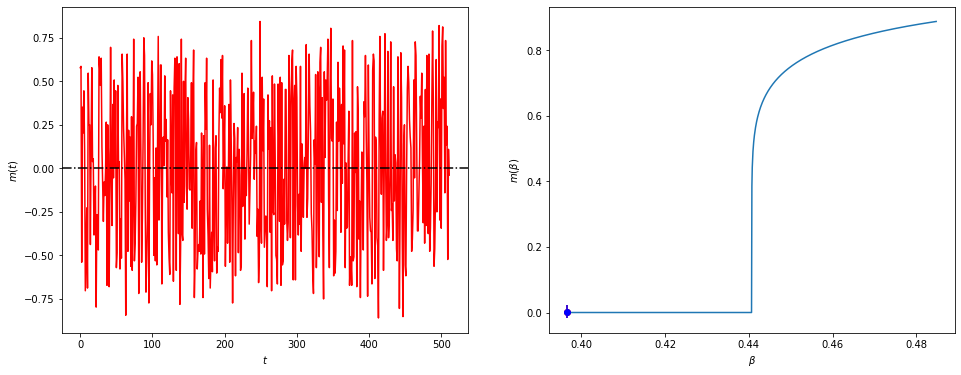

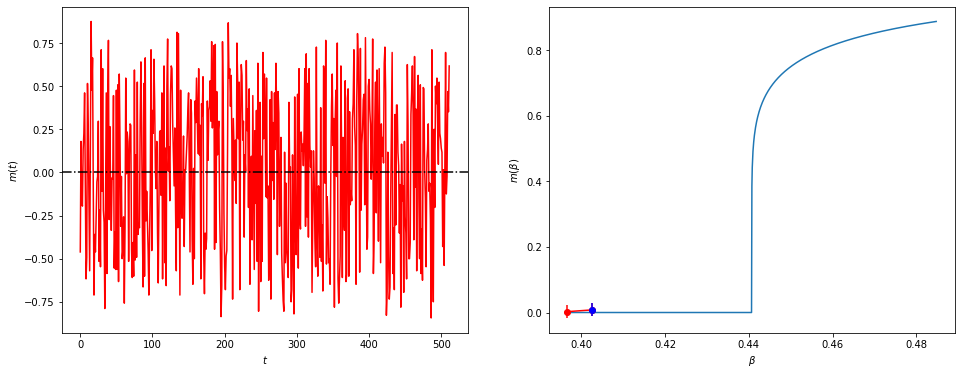

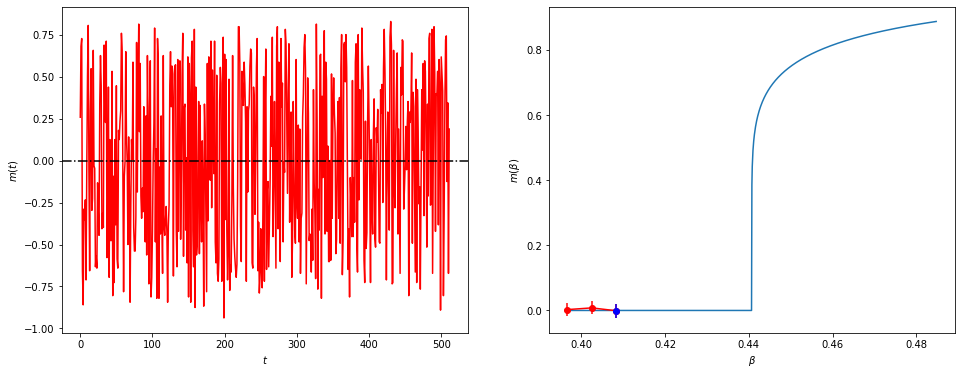

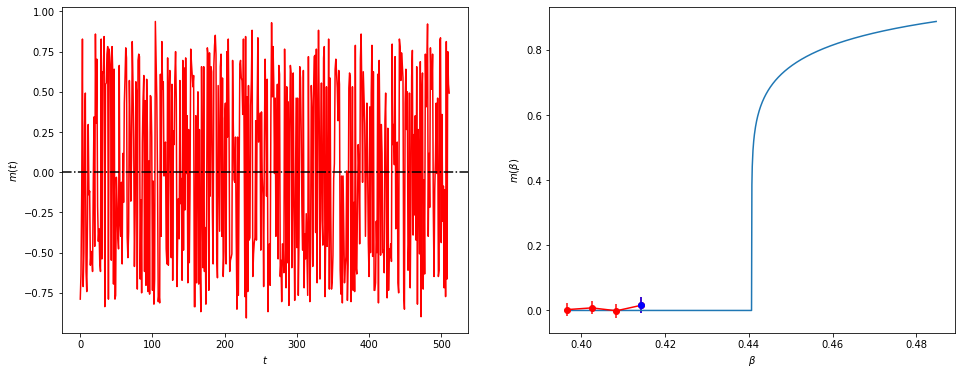

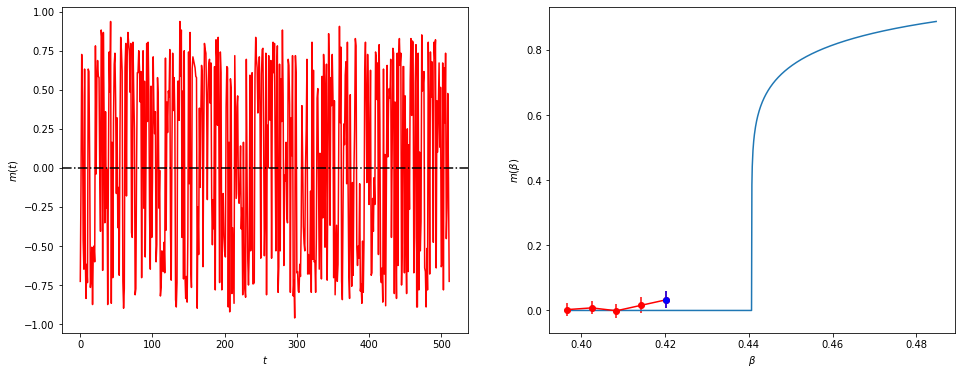

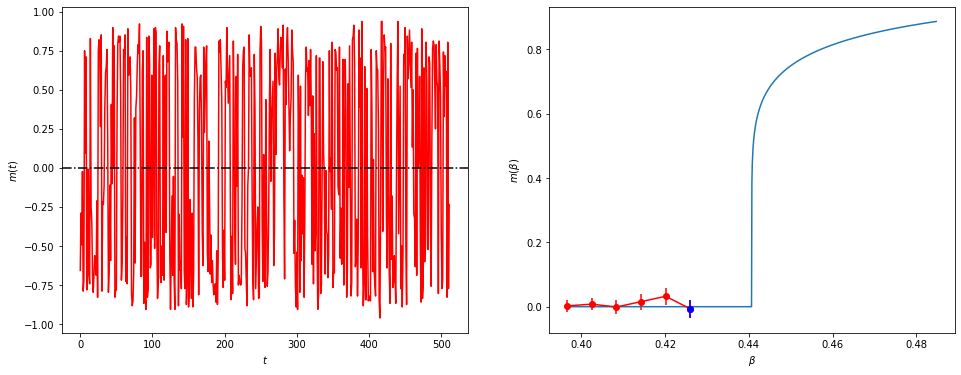

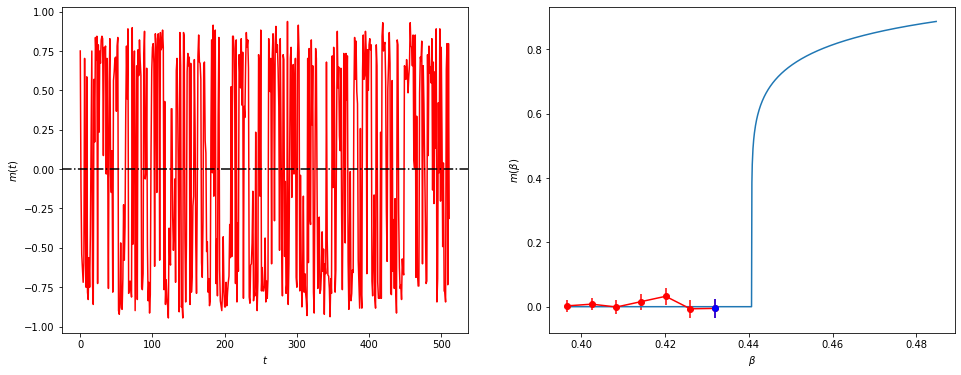

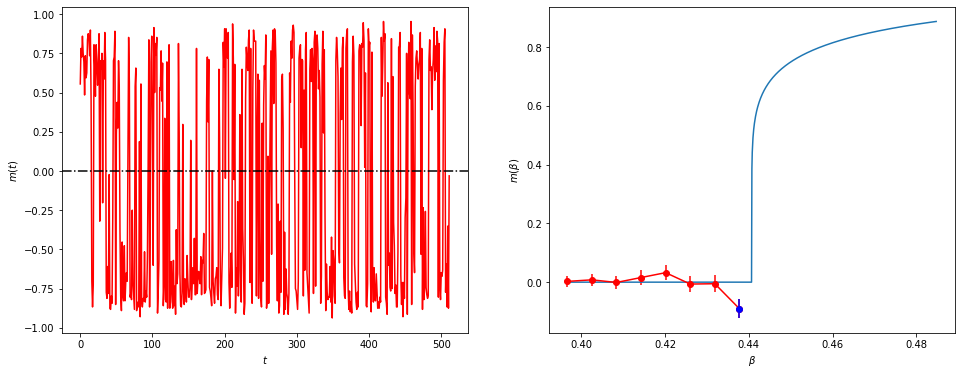

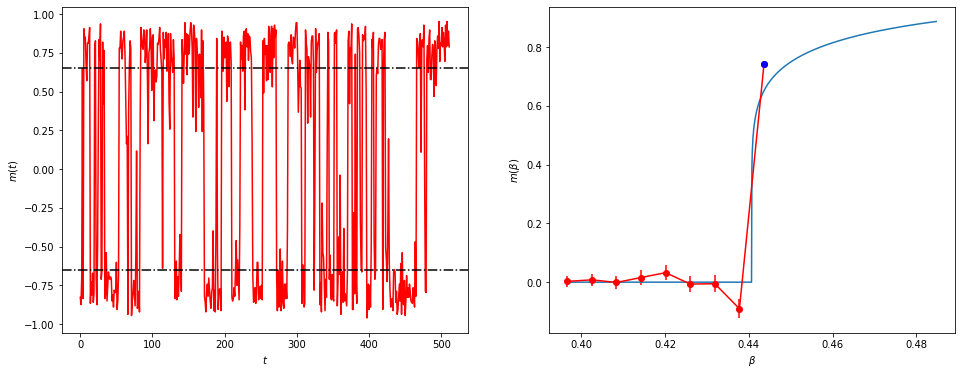

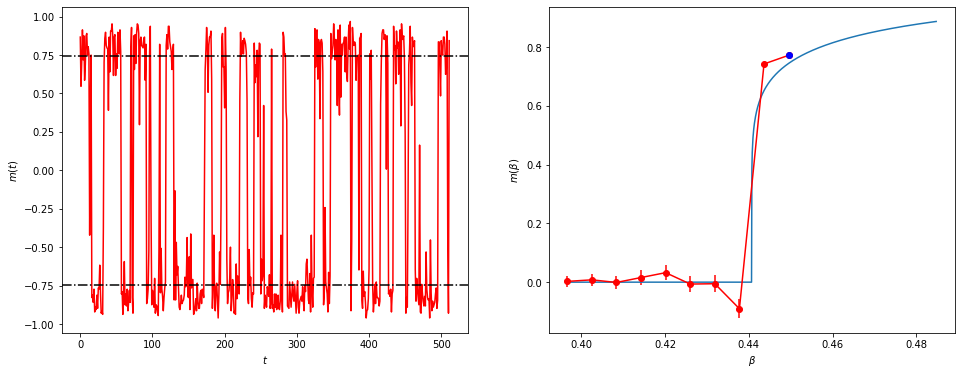

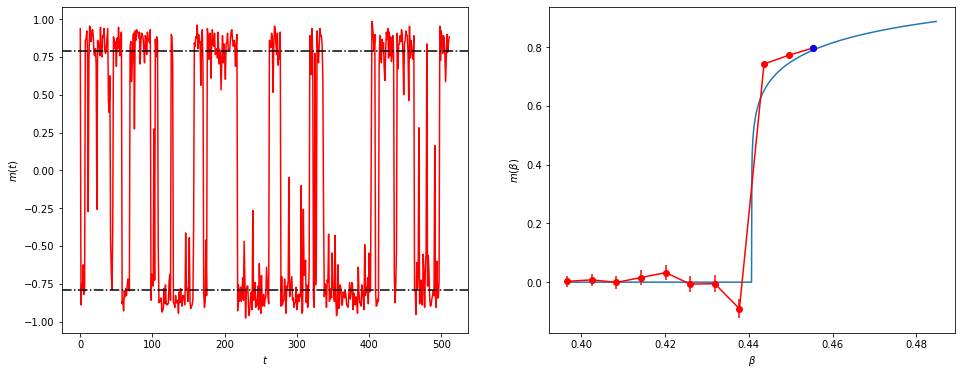

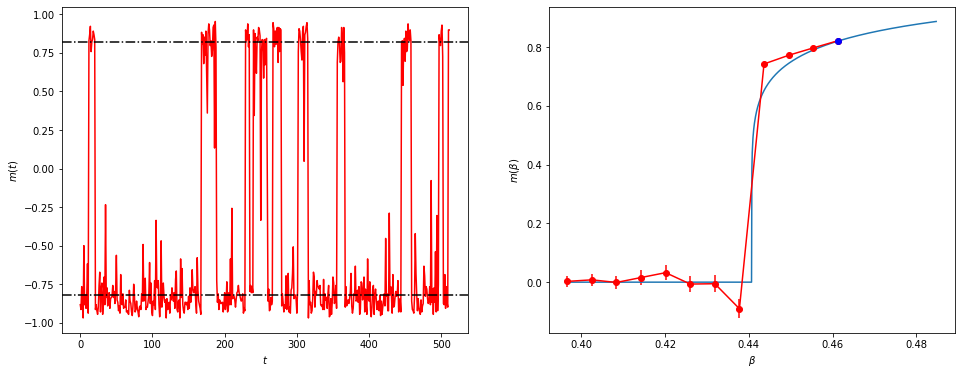

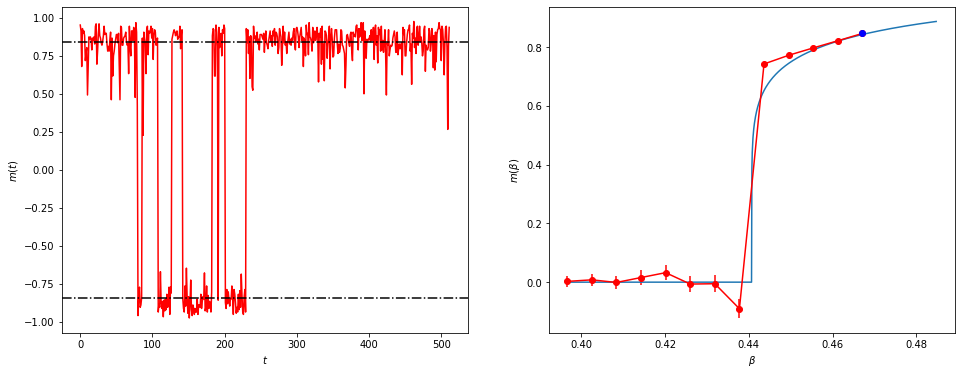

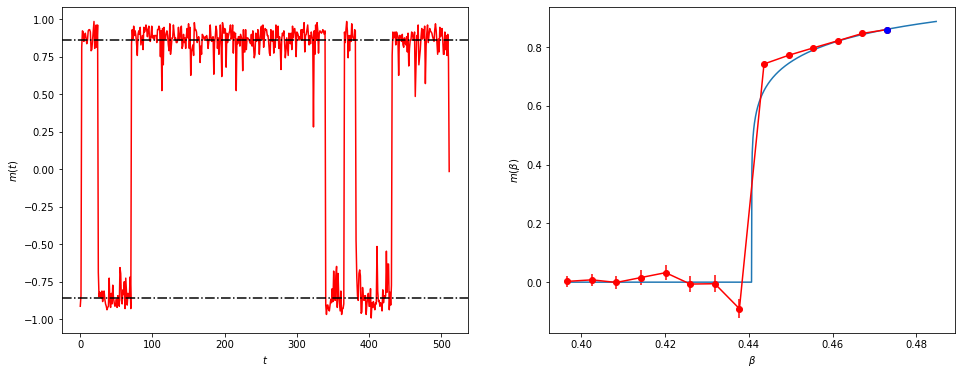

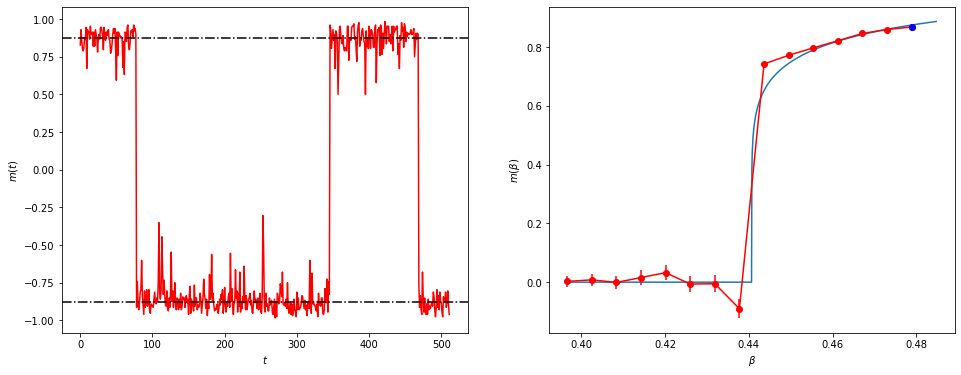

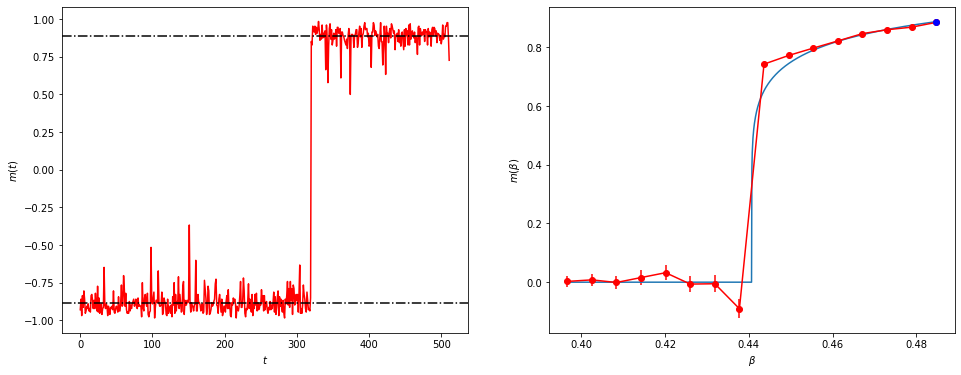

In [42]:
'''
Plottoing the results: one value of beta for each row
Left panel: time sequence of the magnetization
Right panel: average magnetization (small trick below the transition) 
against Onsager's solution
'''
%matplotlib inline
beta_fine = np.linspace((1 + delta_beta_seq_V0[0]) * np.log(1 + np.sqrt(2)) / 2, 
                        (1 + delta_beta_seq_V0[-1]) * np.log(1 + np.sqrt(2)) / 2, 
                        2 ** 10)

M1_onsager_fine = np.array([M1Onsager(_) for _ in beta_fine])
_mag1_aves, _mag1_errs, _betas = [], [], []

_k = 0
'''
Plot loop: click on the arrow to unfold the code
'''
for _delta_beta in delta_beta_seq_V0:
    fig = plt.figure(figsize = (16, 6))
    '''
    Time sequence
    '''
    _ax_mag_time = plt.subplot2grid((1, 2), (0, 0), colspan = 1, rowspan = 1)
    _beta = (1 + _delta_beta) * np.log(1 + np.sqrt(2)) / 2
    _betas += [_beta]
    
    _ax_mag_time.plot(beta_results_V0[_beta]['mag1'], color = 'red')
    if _beta < np.log(1 + np.sqrt(2)) / 2:
        _ax_mag_time.axhline(y = 0, linestyle = '-.', color = 'black')
    else:
        _ax_mag_time.axhline(y = M1Onsager(beta = _beta), linestyle = '-.', color = 'black')
        _ax_mag_time.axhline(y = -M1Onsager(beta = _beta), linestyle = '-.', color = 'black')

    _ax_mag_time.set_xlabel('$t$')
    _ax_mag_time.set_ylabel('$m(t)$')    
        
    '''
    Average magnetization against onsager solution
    '''
    _ax_mag_onsager = plt.subplot2grid((1, 2), (0, 1), colspan = 1, rowspan = 1)
    _ax_mag_onsager.plot(beta_fine, M1_onsager_fine)
    if _beta < np.log(1 + np.sqrt(2)) / 2:
        _ave_mag1, _err_mag1 = \
            np.mean(beta_results_V0[_beta]['mag1']), \
            np.sqrt(np.var(beta_results_V0[_beta]['mag1'])/\
                    len(beta_results_V0[_beta]['mag1']))
        _mag1_aves += [_ave_mag1]
        _mag1_errs += [_err_mag1]
    else:
        _ave_mag1, _err_mag1 = \
            np.mean(np.abs(beta_results_V0[_beta]['mag1'])), \
            np.sqrt(np.var(np.abs(beta_results_V0[_beta]['mag1']))/\
                    len(beta_results_V0[_beta]['mag1']))
        _mag1_aves += [_ave_mag1]
        _mag1_errs += [_err_mag1]

    _ax_mag_onsager.errorbar(_betas, _mag1_aves, _mag1_errs, 
                             marker = 'o', color = 'red')
        
    _ax_mag_onsager.errorbar(_betas[-1:], _mag1_aves[-1:], _mag1_errs[-1:], 
                             marker = 'o', color = 'blue')
    _ax_mag_onsager.set_ylabel('$m(\\beta)$')
    _ax_mag_onsager.set_xlabel('$\\beta$')
    
    plt.show()

In [ ]:
from idpy.IdpyCode.IdpyCode import IdpyLoopProfile

_memory_dict = {'spins': spins_V0, 
                'seeds': numrec_V0.sims_idpy_memory['seeds'], 
                'parity0': NPT_V0.C[Ising2DTypes_V0['SpinType']](0),
                'parity1': NPT_V0.C[Ising2DTypes_V0['SpinType']](1)}

_profile_loop = \
    IdpyLoopProfile(
        [_memory_dict], 
        [
            [
                (_K_UpdateSpins_V0(tenet = tenet_V0, grid = grid_V0, block = block_V0), 
                 ['spins', 'seeds', 'parity0']),
                
                (_K_UpdateSpins_V0(tenet = tenet_V0, grid = grid_V0, block = block_V0), 
                 ['spins', 'seeds', 'parity1'])
            ]
        ]
    )

_profile_loop.Run(range(0, 2 ** 3 + 1, 1))

### *tenet*.End()

The cell below invokes the *tenet* method ```End``` which frees the memory and deletes the context.

In [ ]:
tenet_V0.End()

## ```IdpySims``` Class implementation: V2

In [ ]:
# Development cell
%load_ext autoreload
%autoreload 2

In [ ]:
# Import Statements

'''
Appending the root directory of the idea.deploy project.
This is done explicitly here. 
In the modules this is done in the local __init__.py file
'''
import sys
sys.path.append("../")

'''
Importing numpy
'''
import numpy as np
'''
Import Code from IPython.display for pretty printing
'''
from IPython.display import Code

'''
Importing reduce functional tool
'''
from functools import reduce

'''
Importing languages types
'''
from idpy.IdpyCode import CUDA_T, OCL_T, IDPY_T, GetTenet, GetParamsClean

'''
Importing IdpySims class
'''
from idpy.IdpyCode.IdpySims import IdpySims

'''
Importing IdpyKernel, IdpyFunction, IdpyLoop
'''
from idpy.IdpyCode.IdpyCode import IdpyKernel, IdpyFunction, IdpyLoop

'''
Importing the congruential pseudo-random number generators
'''
from idpy.PRNGS.CRNGS import CRNGS
from idpy.PRNGS.CRNGS import F_Norm as F_Norm_CRNGS

'''
Importing class for custom types
'''
from idpy.Utils.CustomTypes import CustomTypes

'''
Importing dictionary for translating C/C++ types to numpy types
'''
from idpy.Utils.NpTypes import NpTypes

As a first step we need to define the custom types for the simulations, which in this case will be pretty straight-forwardly set to ```int``` giving the ability to the spins to take one of the two values ```+1``` or ```-1```. As we shall see later in this tutorial this choice amount to a pretty large waste of resources, but at the same time provides a very clear implementation that can be used to perform simple double checks of more advanced algorithms.

Finally, choosing to parametrize the relevamt types for the simulation allows to easily change the type later, without any need to re-edit the whole code in a heavy way. So, even if in this moment it might look an unnecessary practice, it helps us building a solid and useful practice.

We also define an ```NpTypes``` object which allows to *translate* the typical ```C/C++``` types into ```numpy``` types which can be specified when decalring ```numpy``` and ```IdpyMemory``` arrays.

In [ ]:
Ising2DTypes_V0 = CustomTypes({'SpinType': 'int', 
                               'LatticeType': 'int',
                               'WeightType': 'float', 
                               'BetaType': 'float', 
                               'EnergyType': 'int'})
NPT_V0 = NpTypes()

The step was pretty straight forward, since for the moment we will only be managing two types in the kernel code.

Let us now define the simulation class

In [ ]:
class Ising2D_V0(IdpySims):
    '''
    class Ising2D_V0
    We declare the __init__ function (constructor) using already
    *args and **kwargs because this benefits the customazibility
    of the class by allowing to pass an arbitrary number of parameters
    that can be esaily managed
    '''
    def __init__(self, *args, **kwargs):
        '''
        params_dict is a common name across the project to indicate
        the dictionary containing the parameters for the class
        '''
        if not hasattr(self, 'params_dict'):
            self.params_dict = {}
        '''
        GetParamsClean: filters the list of needed_params out of kwargs and
        puts it in self.params_dict, what is left is put in _swap_kwargs
        '''
        _swap_kwargs = GetParamsClean(kwargs, [self.params_dict], 
                                      needed_params = ['L', 'beta', 'seed',
                                                       'lang', 'device', 
                                                       'cl_kind', 'custom_types'])        
        '''
        Initializing the parent class
        '''
        IdpySims.__init__(self, *args, **_swap_kwargs)
        '''
        Getting custom types
        '''
        if 'custom_types' in self.params_dict:
            self.custom_types = self.params_dict['custom_types']
        else:
            self.custom_types = Ising2DTypes_V0        
        '''
        We use the (inherited) dictionary sims_vars to store handy quantities
        We need to check for the parity of the system size because we would only
        like to use even linear-size systems in order to update in parallel
        half of the spins at each time step.
        '''
        _L, self.sims_vars['L'] = self.params_dict['L'], self.params_dict['L']
        if _L % 2:
            raise Exception("The lattice linear size L must be even!")
        
        self.sims_vars['dim_sizes'] = \
            np.array([_L, _L], dtype = NPT_V0.C[self.custom_types['SpinType']])
        '''
        Computing the 'volume' in a dimension-independent way
        '''
        self.sims_vars['V'] = reduce(lambda x, y: x * y, self.sims_vars['dim_sizes'])
        
        self.sims_vars['beta'] = self.params_dict['beta']
        '''
        If the 'seed' for the random number generator is not passed set it by default to 1
        '''
        if 'seed' not in self.params_dict:
            self.sims_vars['seed'] = 1
        else:
            self.sims_vars['seed'] = self.params_dict['seed']
        '''
        Here we need to enforce that the lang variable is chosen
        '''
        if 'lang' not in self.params_dict:
            raise Exception("Need to specify parameter 'lang' either CUDA_T or OCL_T")        
                    
        '''
        Getting the tenet for the simulation
        '''
        self.tenet = GetTenet(self.params_dict)
        
        '''
        Setting up congruential random number generator
        The module will try to initialize by default
        We only allocate half of the volume because the algorithm is going to
        update half of the system in parallel
        '''
        print("Trying to use 'MINSTD' congruential pseudo-random number generator")
        self.crng = CRNGS(tenet = self.tenet, lang = self.params_dict['lang'],
                          n_prngs = self.sims_vars['V'] // 2, 
                          seed = self.sims_vars['seed'])
        '''
        We now setup the variables necessary for the launch of the device kernels
        namely number of threads and number of blocks
        '''

    def MainLoop(self):
        pass
        
    '''
    The function End frees up the memory allocated on the device
    '''
    def End(self):
        self.tenet.End()
        
'''
Let us now rename the IdpyFunction tha will be used to obtain normalized 
random numbers. We do this to show how to avoid name clashes among different modules.
During the import we import the class as F_Norm_CRNGS.
Now we will create a dummy class providing a better name
'''
class F_NormRand(F_Norm_CRNGS):
    def __init__(self, *args, **kwargs):
        F_Norm_CRNGS.__init__(self, *args, **kwargs)
        
'''
Let us move now to the definition of the kernel function
'''